In [39]:
%run Module-2-helper.py

In [40]:
# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT = './simulated-data-transformed' 

BEGIN_DATE = "2022-01-15"
END_DATE = "2022-04-20"

print("Load  files")
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.Trans_FRAUD.sum()))

output_feature = "Trans_FRAUD"

input_features = ['Trans_AMOUNT','Trans_DURING_WEEKEND', 'Trans_DURING_NIGHT', 'CUSTOMER_ID_NB_Trans_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'STORE_ID_NB_Trans_1DAY_WINDOW',
       'STORE_ID_RISK_1DAY_WINDOW', 'STORE_ID_NB_Trans_7DAY_WINDOW',
       'STORE_ID_RISK_7DAY_WINDOW', 'STORE_ID_NB_Trans_30DAY_WINDOW',
       'STORE_ID_RISK_30DAY_WINDOW']

Load  files
2323689 transactions loaded, containing 10132 fraudulent transactions


In [41]:
# Number of folds for the prequential validation
n_folds = 4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2022-02-28", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)


In [42]:
# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'Trans_FRAUD','Trans_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }


In [43]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df


In [44]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.760550,0.007122,0.419822,0.015840,0.381429,0.024702,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.440953,0.779055,0.006532,0.464257,0.007255,0.402857,0.018406,2
1,0.767051,0.009392,0.489381,0.011747,0.388214,0.029904,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.524904,0.784937,0.006387,0.530790,0.013025,0.412143,0.019312,3
2,0.773661,0.007533,0.516642,0.016120,0.399286,0.025405,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.606925,0.785644,0.007255,0.557105,0.019200,0.409286,0.023765,4
3,0.774974,0.008803,0.523959,0.016756,0.400000,0.022338,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.692533,0.785504,0.005777,0.553309,0.013548,0.405714,0.017113,5
4,0.767819,0.011742,0.522342,0.015627,0.401071,0.021294,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.781745,0.783250,0.003844,0.519537,0.051682,0.404643,0.015131,6
5,0.754036,0.005699,0.501578,0.020609,0.392500,0.025483,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.869211,0.780377,0.006730,0.509614,0.045779,0.399643,0.015266,7
6,0.746190,0.003101,0.484691,0.015561,0.384643,0.029231,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.951274,0.766523,0.018691,0.505938,0.050618,0.397500,0.015984,8
7,0.739451,0.006154,0.481737,0.020485,0.383929,0.028165,"{'clf__max_depth': 9, 'clf__random_state': 0}",1.033662,0.773066,0.028506,0.486591,0.060649,0.395714,0.017409,9
8,0.734358,0.014654,0.479437,0.017484,0.383214,0.027131,"{'clf__max_depth': 10, 'clf__random_state': 0}",1.114933,0.769319,0.030731,0.498958,0.039274,0.395000,0.016918,10
9,0.757598,0.016951,0.390405,0.027716,0.382500,0.026848,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.801951,0.768372,0.016163,0.392702,0.037631,0.396786,0.018962,20


In [45]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,4,4,3
Validation performance,0.786+/-0.01,0.557+/-0.02,0.412+/-0.02
Test performance,0.774+/-0.01,0.517+/-0.02,0.388+/-0.03
Optimal parameters,5,5,6
Optimal test performance,0.775+/-0.01,0.524+/-0.02,0.401+/-0.02


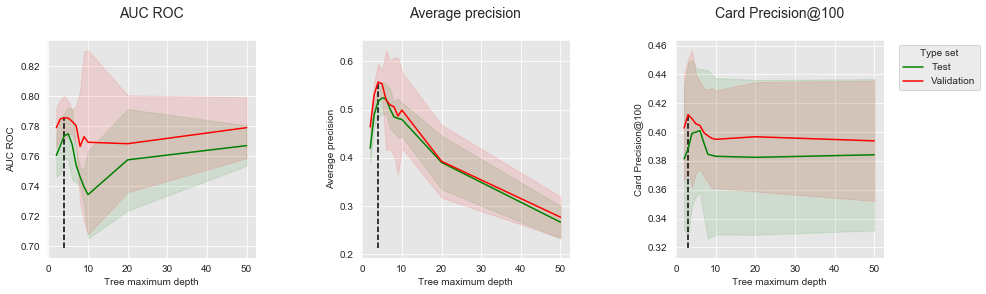

In [46]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)